In [43]:
import matplotlib.pyplot as plt
import skimage
import skfmm 
import torch
import numpy as np
from kornia.filters import spatial_gradient

In [16]:
cha = skimage.data.horse()
nx, ny = cha.shape
dx = 1/nx 
dy = 1/ny
cnt = skimage.measure.find_contours(cha, 0.5)[0]
x = np.linspace(0,1,nx)
y = np.linspace(0,1,ny)

SDF shape representation

In [60]:
u = skfmm.distance(cha-0.5, dx=[dx, dy])
# u = torch.tensor(u[None][None])
# u_grad = spatial_gradient(u)
# ux = u_grad[:,:,0,:,:]
# uy = u_grad[:,:,1,:,:]
# ux_grad = spatial_gradient(ux, normalized=False)
# uxx = ux_grad[:,:,0,:,:]
# uy_grad = spatial_gradient(uy, normalized=False)
# uyy = uy_grad[:,:,1,:,:]
# k = uxx + uyy

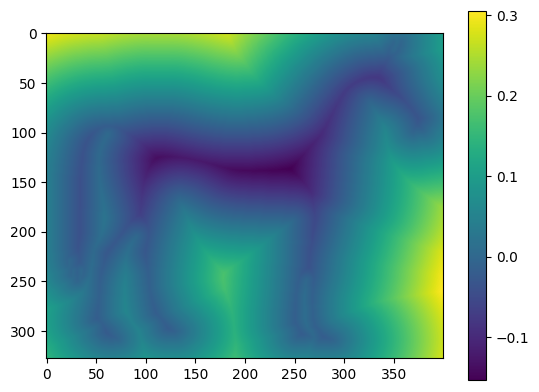

In [63]:
plt.imshow(u)
plt.colorbar()

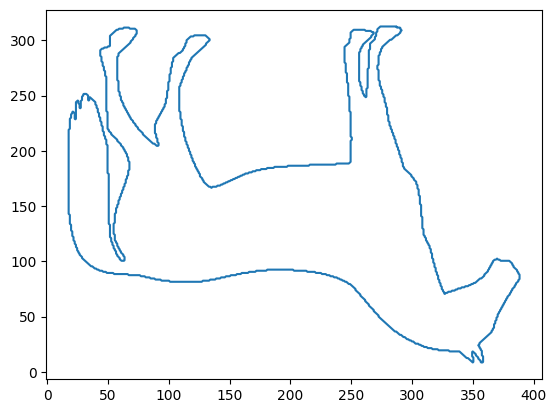

In [42]:
plt.plot(cnt[:,1], cnt[:,0])


In [69]:
import numpy as np
import os 
import glob 
from skimage import segmentation
import monai.transforms as transforms
from monai.data import CacheDataset, DataLoader, Dataset
import skfmm
from tqdm import tqdm 
# from utils import levelset2boundary, levelset2boundary2D
from torchvision.transforms.functional import rgb_to_grayscale

In [71]:
origin_dir='/dataset/CXR'
margin = 256 

In [72]:
imgs_dir = os.path.join(origin_dir, 'CXR_png')
segs_dir = os.path.join(origin_dir, 'LeftMask_png')

imgs = []
segs = []
nms = [nm.split('.')[0] for nm in os.listdir(imgs_dir)]
for nm in nms:
    img_path = os.path.join(imgs_dir, nm + '.png')
    seg_path = os.path.join(segs_dir, nm + '_mask.png')

    if os.path.isfile(img_path) & os.path.isfile(seg_path):
        imgs.append(img_path)
        segs.append(seg_path)

files = [{"image": img, "label": seg} for img, seg in zip(imgs, segs)]

In [73]:
trans =  transforms.Compose(
        [
            transforms.LoadImaged(keys=['image', 'label']),
            transforms.EnsureChannelFirstd(keys=["image", "label"]),
            transforms.CropForegroundd(keys=['image', 'label'], source_key='label', margin=margin),])

In [74]:
ds = CacheDataset(
        data=files, transform=trans,
        cache_rate=1.0, num_workers=8)

Loading dataset: 100%|██████████| 568/568 [00:50<00:00, 11.26it/s]


In [152]:
for sample in tqdm(ds, total=len(ds)):
    image = sample['image']
    break
    if image.shape[0] != 1:
        image = rgb_to_grayscale(image) 
        break 

  0%|          | 0/568 [00:00<?, ?it/s]


In [154]:
image.max()

tensor(255.)

In [97]:
def calc_sdf(mask, dx, dy):
    nx, ny = mask.shape
    cnt = skimage.measure.find_contours(mask, 0.5)[0]
    sdf = skfmm.distance(mask-0.5, dx=[dx, dy])
    return sdf

In [132]:
image = sample['image']
mask = sample['label'][0]
nx, ny = mask.shape 
dx, dy = 1/nx, 1/ny
sdf = torch.tensor(calc_sdf(mask, dx, dy))

In [156]:
resize(image[None], (256, 256))[0].min()

tensor(0.)

In [127]:
import torch.nn.functional as F

In [140]:
def resize(image, size):
    image_resize = F.interpolate(image, size, mode='bilinear', align_corners=True)
    return image_resize

In [141]:
image_lr = resize(image[None], size=[256, 256])

In [133]:
image_lr = F.interpolate(image[None], (256, 256), mode='bilinear', align_corners=True)
sdf_lr = F.interpolate(sdf[None][None], (256, 256), mode='bilinear', align_corners=True)

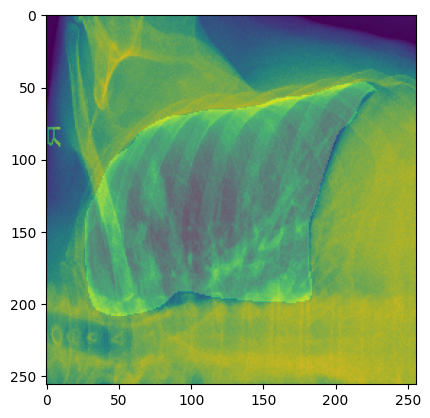

In [138]:
plt.imshow(image_lr[0,0])
plt.imshow(sdf_lr[0,0] > 0, alpha=0.2)

In [124]:
# u = torch.tensor(sdf[None][None])
# u_grad = spatial_gradient(u, normalized=False)
# ux = u_grad[:,:,0,:,:] / dx
# uy = u_grad[:,:,1,:,:] / dy
# ux_grad = spatial_gradient(ux, normalized=False)
# uxx = ux_grad[:,:,0,:,:] / dx
# uy_grad = spatial_gradient(uy, normalized=False)
# uyy = uy_grad[:,:,1,:,:] / dy
# k = uxx + uyy

In [117]:
m = ((sdf-0.001)>0).astype('float') - ((sdf + 0.001) > 0).astype('float')